### model 22 にて途中で止まってしまった学習をチェックポイントと csv から復元する

In [1]:
import os
import re
import datetime
import random
import numpy as np
from PIL import Image
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split

from tensorflow.keras import models, layers
from tensorflow.keras.applications import Xception
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from google.colab import drive
drive.mount('/content/drive')


def generate_data(x, t, num=5):
  datagen = ImageDataGenerator(
    #rotation_range=180,     # randomly rotate images in the range
    zoom_range=0.2,         # randomly zoom image
    width_shift_range=0.2,  # randomly shift images horizontally
    height_shift_range=0.2, # randomly shift images vertically
    horizontal_flip=True,   # randomly flip images horizontally
    #vertical_flip=True      # randomly flip images vertically
  )

  x_list = []
  t_list = []

  x_array = np.expand_dims(x, axis=0)

  datagen.fit(x_array)

  iter = datagen.flow(x_array, batch_size=1)

  for i in range(num):
    ret = iter.next()
    #print(ret.shape, ret.dtype)
    x_list.append(ret[0])
    t_list.append(t)

  return x_list, t_list


def prepare_data(gen_num=5):
  x, t = [], []

  categorized_dir_paths = glob('/content/drive/My Drive/kikagaku/novelapp/data/images/categorized-2/*')

  for dir_path in categorized_dir_paths:
    category_id = os.path.basename(dir_path)
    image_paths = glob(os.path.join(dir_path, '*'))
    print(datetime.datetime.now().isoformat(), 'Category', category_id, ':', len(image_paths))

    for i, p in enumerate(image_paths):
      book_id = re.sub(r'(_.*$)', '', os.path.basename(p))

      if i % 30 == 0:
          print(datetime.datetime.now().isoformat(), 'Image:', i, book_id, category_id)

      try:
          img = Image.open(p)
          img_resize = img.resize((229, 229))
          img_np = np.array(img_resize) / 255.0

          x.append(img_np)
          t.append(category_id)

          x_gen, t_gen = generate_data(img_np, category_id, gen_num)
          x.extend(x_gen)
          t.extend(t_gen)

      except Exception as e:
          print(datetime.datetime.now().isoformat(), 'Error:', e)

  return x, t


def reset_seed(seed=0):
    os.environ['PYTHONHASHSEED'] = '0'
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

reset_seed(0)


x, t = prepare_data(5)
print(len(x), len(t))

x = np.array(x).astype('f')
t = np.array(t).astype('f')
print(x.shape, t.shape)

x_train, x_val, t_train, t_val = train_test_split(x, t, test_size=0.3, random_state=0)
print(x_train.shape, x_val.shape)

category_count = len(np.unique(t))
print(np.unique(t))
print(category_count)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
2020-06-25T08:26:35.009638 Category 0 : 117
2020-06-25T08:26:35.011301 Image: 0 1015 0
2020-06-25T08:26:47.650158 Image: 30 1228 0
2020-06-25T08:27:00.770547 Image: 60 1106 0
2020-06-25T08:27:13.485406 Image: 90 1129 0
2020-06-25T08:27:23.911055 Category 1 : 119
2020-06-25T08:27:23.911772 Image: 0 3636 1
2020-06-25T08:27:36.990667 Image: 30 3722 1
2020-06-25T08:27:49.867661 Image: 60 3832 1
2020-06-25T08:28:01.614672 Image: 90 3777 1
2020-06-25T08:28:11.998127 Category 2 : 129
2020-06-25T08:28:11.998817 Image: 0 3601 2
2020-06-25T08:28:24.322209 Image: 30 3884 2
2020-06-25T08:28:35.558874 Image: 60 3778 2
2020-06-25T08:28:49.682656 Image: 90 3853 2
2020-06-25T08:29:00.523350 Image: 120 1502 2
2020-06-25T08:29:03.975158 Category 3 : 111
2020-06-25T08:29:03.976531 Image: 0 3312 3
2020-06-25T08:29:15.416258 Image: 30 2350 3
2020-06-25T08:29:26.784785 Image: 60 3

In [2]:
def create_model():
  model_fine = Xception(include_top=False, weights='imagenet', input_shape=x_train.shape[1:])
  
  for layer in model_fine.layers[:100]:
      layer.trainable = False
  
  model = models.Sequential()
  model.add(model_fine)
  
  model.add(layers.Flatten())
  
  model.add(layers.BatchNormalization())
  model.add(layers.Dense(32, activation='relu'))
  model.add(layers.Dropout(0.1))
  model.add(layers.Dense(category_count, activation='softmax'))
  
  optimizer = keras.optimizers.Adagrad(lr=0.004705)
  
  model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

  return model

In [3]:
from tensorflow.keras.callbacks import ModelCheckpoint

#checkpoint_path = '/content/drive/My Drive/kikagaku/novelapp/etc/model/model22_training/cp-{epoch:04d}.ckpt'
checkpoint_path = '/content/drive/My Drive/kikagaku/novelapp/etc/model/model22_training/cp-4.ckpt'

In [5]:
#model = keras.experimental.load_from_saved_model(checkpoint_path)
#new_model.summary()

In [14]:
#saved_model_path = os.path.join(checkpoint_path, 'saved_model.pb')
#print(saved_model_path)
#new_model = tf.keras.experimental.load_from_saved_model(saved_model_path)
new_model =tf.keras.models.load_model(checkpoint_path)
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 7, 7, 2048)        20861480  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 100352)            401408    
_________________________________________________________________
dense (Dense)                (None, 32)                3211296   
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 132       
Total params: 24,474,316
Trainable params: 24,219,084
Non-trainable params: 255,232
______________________________________

In [15]:
loss, acc = new_model.evaluate(x_val, t_val, verbose=2)
print(loss, acc)

27/27 - 9s - loss: 0.6947 - accuracy: 0.8658
0.6947095394134521 0.8658109903335571


In [16]:
# checkpoint = ModelCheckpoint(filepath=checkpoint_path,
#                              monitor='val_accuracy',
#                              mode='max',
#                              save_best_only=True,
#                              save_weights_only=False,
#                              period=1,
#                              verbose=0)

In [17]:
# print(datetime.datetime.now().isoformat(), 'Start')

# model = create_model()

# history = model.fit(
#     x_train,
#     t_train,
#     batch_size=32,
#     epochs=100,
#     verbose=0,
#     validation_data=(x_val, t_val),
#     callbacks=[checkpoint]
# )

# print(datetime.datetime.now().isoformat(), 'End')

# results = pd.DataFrame(history.history)
# results[['loss', 'val_loss']].plot()
# results[['accuracy', 'val_accuracy']].plot()

In [18]:
history_csv_path = '/content/drive/My Drive/kikagaku/novelapp/etc/model/model22_training/cp-4_history.csv'

results = pd.read_csv(history_csv_path)
results

,Unnamed: 0,loss,accuracy,val_loss,val_accuracy
0,0,2.305697,0.470235,1.245156,0.543757
1,1,0.437880,0.845423,1.170221,0.632439
2,2,0.137145,0.962981,1.045045,0.704784
3,3,0.075216,0.983492,0.901717,0.726955
4,4,0.041077,0.993997,0.760707,0.753792
...,...,...,...,...,...
995,995,0.000042,1.000000,0.737603,0.849475
996,996,0.000114,1.000000,0.734033,0.848308
997,997,0.000073,1.000000,0.734613,0.847141
998,998,0.000053,1.000000,0.733323,0.848308


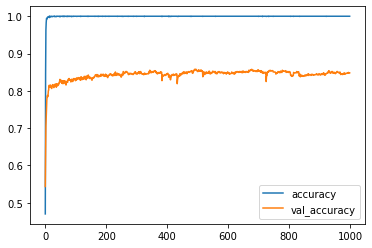

In [19]:
results[['accuracy', 'val_accuracy']].plot()

In [20]:
hdf5_path = '/content/drive/My Drive/kikagaku/novelapp/etc/model/model23.h5'

model.save(hdf5_path, include_optimizer=False)